In [1]:
import json
import requests
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from PIL import Image
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm_notebook
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (15,6)

In [2]:
def get_html_newegg(keyword, page):
    url = f"https://www.newegg.com/p/pl?d={keyword}&page={page}"
    req = requests.get(url)
    soup_html = BeautifulSoup(req.text)
    return soup_html

In [3]:
def store_results(results_dict, soup_html, save_filename=None):
    if results_dict != {}:
        last_index = list(results_dict.keys())[-1]
    else:
        last_index = -1

    i = last_index + 1
    for item in soup_html.find_all(name="div", attrs={"class": "item-container"}):
        
        # get brand of gpu
        brand = item.find('div', attrs={'class', 'item-branding'})
        if brand is None: continue
        brand = brand.img
        if brand is None: continue
        brand = brand['title']
        
        # get product images + product names
        img = item.find('img')
        product_title = img["title"]
        prduct_image = img["src"]
        
        # get current price
        price = item.find('li', attrs={"class":"price-current"})
        if price is None: continue
        price = price.text
        price = price.encode('unicode_escape').decode()
        price = price.split("\\")[0]
        
        # get shipping fee
        shipping_fee = item.find('li', attrs={"class":"price-ship"})
        if shipping_fee is None: continue
        shipping_fee = shipping_fee.text
        
        results_dict[i] = {}
        results_dict[i]['brand'] = brand
        results_dict[i]["title"] = product_title
        results_dict[i]["image"] = prduct_image
        results_dict[i]["price"] = price
        results_dict[i]["shippingFee"] = shipping_fee
        i += 1

    if not save_filename is None:
        with open(save_filename, 'w') as file:
            json.dump(results_dict, file, indent=4, sort_keys=True)
#         print("saved json")

In [4]:
def show_image(results_dict, index):
    brand = results_dict[index]['brand']
    image_title = results_dict[index]['title']
    image_url = results_dict[index]['image']
    price = results_dict[index]['price']
    shipping_fee = results_dict[index]['shippingFee']
    image_req = requests.get(image_url, stream=True).raw
    image_read = Image.open(image_req)
    display(image_read)
    print(f"{brand} | {price} | {shipping_fee}")
    print(image_title)

In [5]:
KEY_WORD = 'monitor'
TOTAL_PAGES = 15
results_dict = {}

for num_page in tqdm_notebook(range(TOTAL_PAGES)):
    soup_html = get_html_newegg(KEY_WORD, num_page+1)
    store_results(results_dict, soup_html, save_filename=f"Newegg_{KEY_WORD}.json")

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
with open(f"Newegg_{KEY_WORD}.json", 'r') as file:
    data = json.load(file)
print(f"Total data: {len(data)}")

Total data: 501


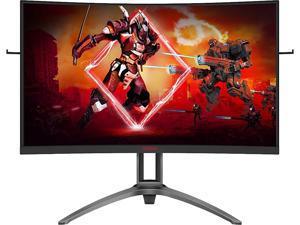

AOC Monitors | $459.99 | $4.99 Shipping
AOC Agon AG322QCX 31.5" 16:9 Curved QHD 144Hz Gaming Monitor, Internal Speakers


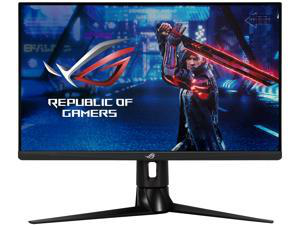

ASUS | $487.99 | Free Shipping
ASUS ROG Strix 27" 1440P HDR Gaming Monitor (XG27AQ) - QHD (2560 x 1440), Fast IPS, 170Hz, 1ms, G-SYNC Compatible, Extreme Low Motion Blur Sync, Eye Care, HDMI DisplayPort USB 3.0 Hub, DisplayHDR 400


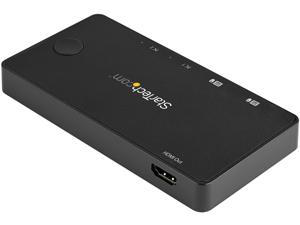

STARTECH | $116.69 | $8.64 Shipping
StarTech.com SV211HDUC 2 Port USB C KVM Switch - 4K 60Hz HDMI - Compact Dual Port UHD USB Type C Desktop Mini KVM Switch with USB C Cables - Bus Powered - MacBook iPad Pro ThinkPad IdeaPad EliteBook


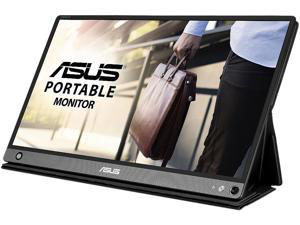

ASUS | $317.99 | Free Shipping
ASUS ZenScreen GO MB16AHP 15.6" Full HD 1920x1080 USB Type-C Micro-HDMI Flicker-Free Blue Light Filter Built-in Battery Portable IPS Monitor


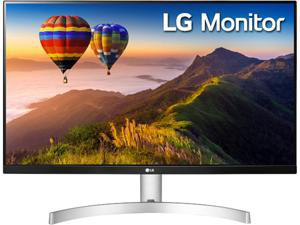

LG Electronics | $135.99 | $4.99 Shipping
LG 27MN60T-W 27" 1920 x 1080 75 Hz FreeSync (AMD Adaptive Sync) A Grade Monitor


In [7]:
for i in np.random.randint(low=0, high=len(data), size=5):
    index = str(i)
    show_image(data, index)

In [8]:
df = pd.read_json(f'Newegg_{KEY_WORD}.json', orient='index')
df.head()

,brand,image,price,shippingFee,title
0,Acer America,https://c1.neweggimages.com/ProductImageCompre...,$189.99,Free Shipping,"Acer XF Series XF270H Bbmiiprx 27"" Full HD 192..."
1,MSI,https://c1.neweggimages.com/ProductImageCompre...,$179.99,$4.99 Shipping,"MSI Optix G24C 24"" (Actual size 23.6"") Full HD..."
2,GIGABYTE,https://c1.neweggimages.com/ProductImageCompre...,$319.99,Free Shipping,"GIGABYTE G32QC A 32"" 165Hz 2K QHD 1ms (MPRT), ..."
3,SAMSUNG,https://c1.neweggimages.com/ProductImageCompre...,"$1,199.99",Free Shipping,"SAMSUNG Odyssey G9 Series C49G97T 49"" Dual QHD..."
4,Z-EDGE,https://c1.neweggimages.com/ProductImageCompre...,$309.99,Free Shipping,"Z-EDGE UG30 30"" Ultrawide 21:9 WFHD 2560x1080 ..."


In [9]:
def get_price_from_string(x): 
    if x == '' : 
        return np.nan
    else: 
        return float(x.replace(",","").strip("$"))
    
def get_shipping_from_string(x):
    if x == '' : 
        return np.nan
    elif x in ['Free Shipping', 'Special Shipping'] : 
        return 0
    else: 
        for s in x.split(" "):
            if '$' in s:
                return float(s.strip('$'))

In [10]:
df['price_float'] = df['price'].apply(get_price_from_string)
df['shippingFee_float'] = df['shippingFee'].apply(get_shipping_from_string)

In [11]:
df.head()

,brand,image,price,shippingFee,title,price_float,shippingFee_float
0,Acer America,https://c1.neweggimages.com/ProductImageCompre...,$189.99,Free Shipping,"Acer XF Series XF270H Bbmiiprx 27"" Full HD 192...",189.99,0.00
1,MSI,https://c1.neweggimages.com/ProductImageCompre...,$179.99,$4.99 Shipping,"MSI Optix G24C 24"" (Actual size 23.6"") Full HD...",179.99,4.99
2,GIGABYTE,https://c1.neweggimages.com/ProductImageCompre...,$319.99,Free Shipping,"GIGABYTE G32QC A 32"" 165Hz 2K QHD 1ms (MPRT), ...",319.99,0.00
3,SAMSUNG,https://c1.neweggimages.com/ProductImageCompre...,"$1,199.99",Free Shipping,"SAMSUNG Odyssey G9 Series C49G97T 49"" Dual QHD...",1199.99,0.00
4,Z-EDGE,https://c1.neweggimages.com/ProductImageCompre...,$309.99,Free Shipping,"Z-EDGE UG30 30"" Ultrawide 21:9 WFHD 2560x1080 ...",309.99,0.00


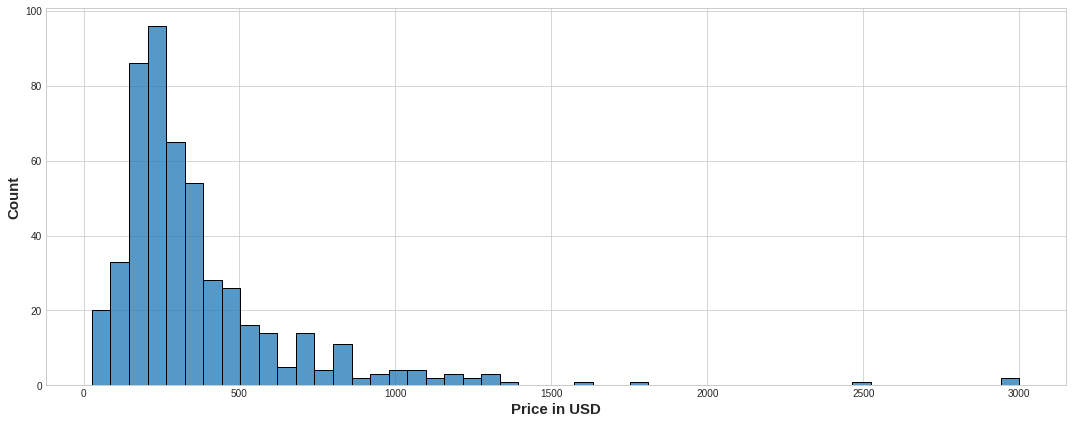

In [12]:
sns.histplot(data=df, x='price_float', bins=50)
font = {'family':'sans-serif', 'weight':'bold', 'size':15}
plt.xlabel("Price in USD", fontdict=font)
plt.ylabel("Count", fontdict=font)
plt.tight_layout()
plt.show()

In [13]:
price_by_brand = df.groupby('brand').mean()
price_by_brand.head()

,price_float,shippingFee_float
brand,,
AOC Monitors,293.490000,6.413333
AORUS,734.990000,3.072727
ASUS,491.939492,2.212373
ATEN,191.902500,0.000000
Acer America,324.416393,3.223115


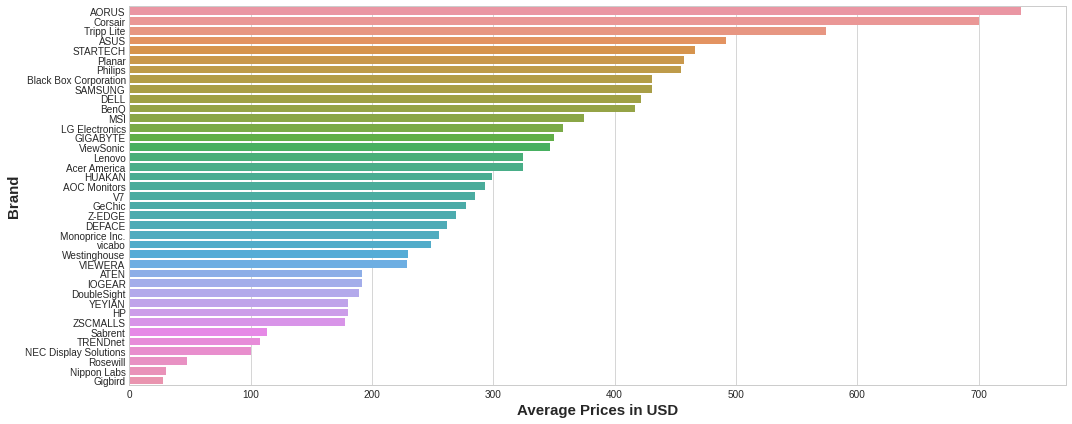

In [14]:
sns.barplot(data=price_by_brand, y=price_by_brand.index, x='price_float', 
            order=price_by_brand.sort_values("price_float", ascending=False).index)
font = {'family':'sans-serif', 'weight':'bold', 'size':15}
plt.xlabel("Average Prices in USD", fontdict=font)
plt.ylabel("Brand", fontdict=font)
plt.tight_layout()
plt.show()

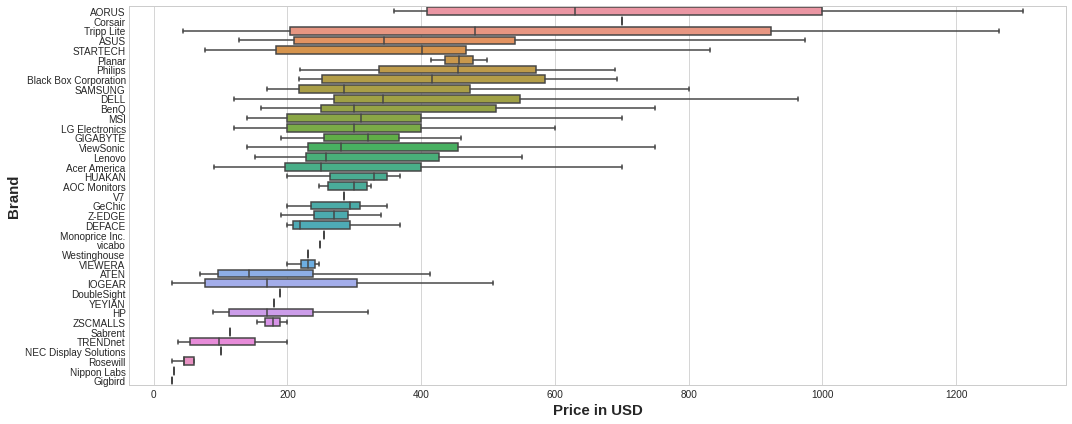

In [15]:
sns.boxplot(data=df, x='price_float', y='brand', showfliers=False,
            order=df.groupby('brand').mean().sort_values('price_float', ascending=False).index)
font = {"size":15, "weight":"bold"}
plt.xlabel("Price in USD", fontdict=font)
plt.ylabel("Brand", fontdict=font)
plt.tight_layout()
plt.show()

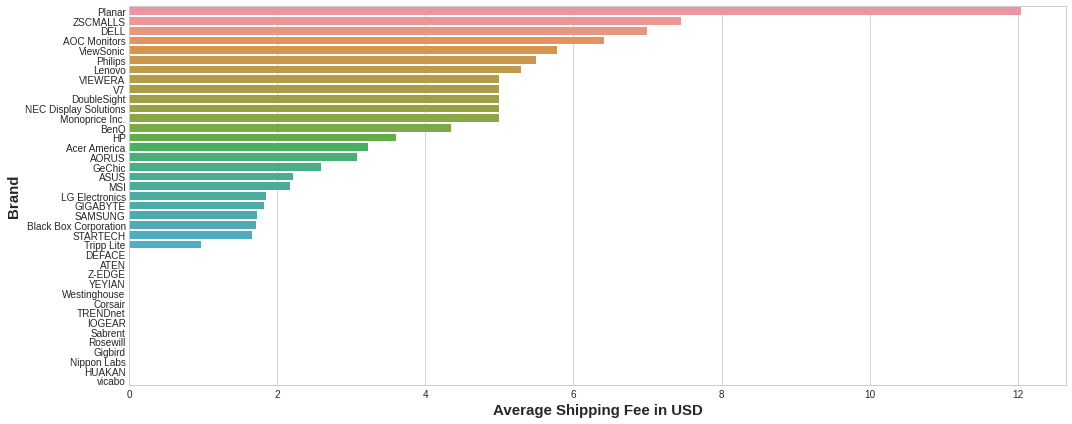

In [16]:
sns.barplot(data=price_by_brand, 
            y=price_by_brand.index, 
            x='shippingFee_float',
            orient='h',
            order=price_by_brand.sort_values("shippingFee_float", ascending=False).index)
font = {"size":15, "weight":"bold"}
plt.xlabel("Average Shipping Fee in USD", fontdict=font)
plt.ylabel("Brand", fontdict=font)
plt.tight_layout()
plt.show()

In [17]:
product_by_brand = df[['brand', 'title']].groupby('brand').count()
product_by_brand.sort_values('title', ascending=False, inplace=True)
product_by_brand.head()

,title
brand,
Acer America,61
ASUS,59
MSI,45
SAMSUNG,40
ViewSonic,39


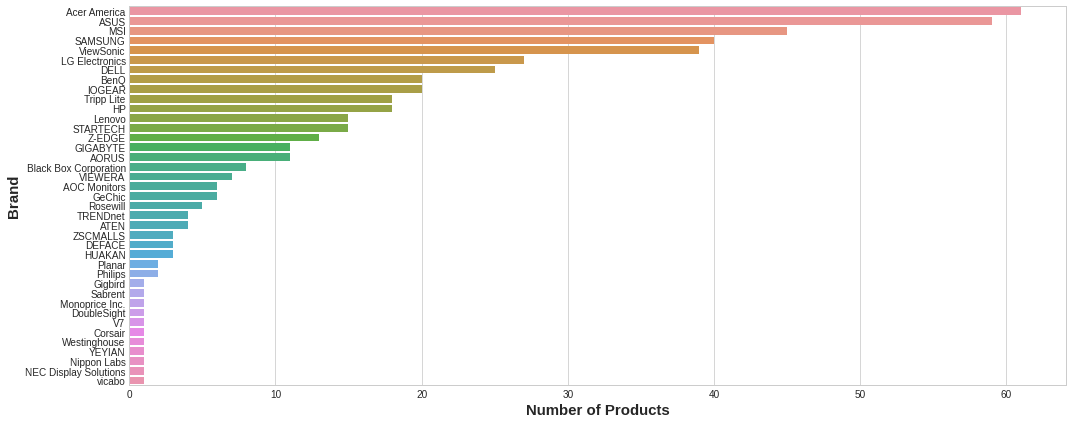

In [18]:
sns.barplot(data=product_by_brand, x='title', y=product_by_brand.index)
font = {'size':15, 'weight':'bold'}
plt.xlabel('Number of Products', fontdict=font)
plt.ylabel('Brand', fontdict=font)
plt.tight_layout()
plt.show()